In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' # import from shell

In [ ]:
import tensorflow as tf
import sklearn
from PIL import Image
import numpy as np
import pickle, glob, time, logging
from tqdm import tqdm
from cleverhans import utils_tf
from util import cvt2Image, sparse_tuple_from
from calamari_ocr.ocr.backends.tensorflow_backend.tensorflow_model import TensorflowModel
from calamari_ocr.ocr import Predictor

checkpoint = '/home/chenlu/calamari/models/antiqua_modern/4.ckpt.json'
predictor = Predictor(checkpoint=checkpoint, batch_size=1, processes=10)
network = predictor.network
sess, graph = network.session, network.graph
codec = network.codec
charset = codec.charset
encode, decode = codec.encode, codec.decode
code2char, char2code = codec.code2char, codec.char2code

In [ ]:
# build graph
with graph.as_default():
    # _ 是data_iterator如果是dataset input的话
    inputs, input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders(
    )
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, log_prob = \
                        network.create_network(inputs, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    loss = tf.nn.ctc_loss(labels=targets,
                          inputs=time_major_logits,
                          sequence_length=output_seq_len,
                          time_major=True,
                          ctc_merge_repeated=True,
                          ignore_longer_outputs_than_inputs=True)
    loss = -tf.reduce_mean(loss, name='loss')
    grad, = tf.gradients(loss, inputs)

    # Normalize current gradient and add it to the accumulated gradient
    red_ind = list(range(1, len(grad.get_shape())))
    avoid_zero_div = tf.cast(1e-12, grad.dtype)
    divisor = tf.reduce_mean(tf.abs(grad), red_ind, keepdims=True)
    norm_grad = grad / tf.maximum(avoid_zero_div, divisor)

    m = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="momentum")
    acc_m = m + norm_grad

    grad = acc_m
    # ord=np.inf
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation_inf = utils_tf.mul(0.01, optimal_perturbation)
    # ord=1
    abs_grad = tf.abs(grad)
    max_abs_grad = tf.reduce_max(abs_grad, axis=red_ind, keepdims=True)
    tied_for_max = tf.to_float(tf.equal(abs_grad, max_abs_grad))
    num_ties = tf.reduce_sum(tied_for_max, axis=red_ind, keepdims=True)
    optimal_perturbation = tf.sign(grad) * tied_for_max / num_ties
    scaled_perturbation_1 = utils_tf.mul(0.01, optimal_perturbation)
    # ord=2
    square = tf.maximum(1e-12, tf.reduce_sum(tf.square(grad), axis=red_ind, keepdims=True))
    optimal_perturbation = grad / tf.sqrt(square)
    scaled_perturbation_2 = utils_tf.mul(0.01, optimal_perturbation)

In [ ]:
font_name = 'Arial'
case = 'easy'
pert_type = 'inf'
eps = 0.2
eps_iter = 1
nb_iter = 1000

# load image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
input_img, len_x, target_txt = input_img[:100], len_x[:100], target_txt[:100]

# set logger
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%a, %d %b %Y %H:%M:%S',
    handlers={
        logging.FileHandler(filename=f'attack_result/{title}.log',
                            mode='a',
                            encoding='utf-8')
    })

# run attack
batch_size = 100
clip_min, clip_max = 0.0, 1.0
target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
with graph.as_default():
    adv_img = input_img.copy()
    m0 = np.zeros(input_img.shape)
    record_iter = np.zeros(input_img.shape[0])  # 0代表没成功

    start = time.time()
    for i in tqdm(range(nb_iter)):
        # perform attack
        batch_iter = len(input_img) // batch_size
        batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
        for batch_i in range(batch_iter):
            batch_input_img = input_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_tmp_y = [np.asarray([c - 1 for c in encode(t)]) for t in batch_target_txt]
            batch_y = sparse_tuple_from(batch_tmp_y)
            batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]
            scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
            batch_pert = sess.run(scaled_perturbation, # pert type
                                  feed_dict={
                                      inputs: batch_adv_img,
                                      input_seq_len: batch_len_x,
                                      m: batch_m0,
                                      targets: batch_y,
                                      dropout_rate: 0,
                                  })
            batch_pert[batch_record_iter != 0] = 0
            batch_adv_img = batch_adv_img + eps_iter * batch_pert
            batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
            batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
            adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img

        # check whether attack success
        record_adv_text = []
        for batch_i in range(batch_iter):
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_text = sess.run(decoded,
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          dropout_rate: 0,
                                      })
            batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
            record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
            for j in range(len(batch_target_index)):
                # attack img idx_j successfully at iter i
                idx_j = batch_size * batch_i + j
                adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                    record_iter[idx_j] = i

        # check whether all examples are successful
        if np.sum(record_iter == 0) == 0:
            break

    duration = time.time() - start
    logging.info(f"{i} break. Time cost {duration:.4f} s")

with open(f'attack_result/{title}.pkl', 'wb') as f:
    pickle.dump((adv_img, record_adv_text, record_iter, (duration, i),), f)

In [ ]:
with open(f'attack_result/Arial-easy-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, i) = pickle.load(f)

In [ ]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/Arial-easy.pkl', 'rb') as f:
    (easy_img_list, easy_input_img, easy_len_x, easy_gt_txt, easy_target_txt) = pickle.load(f)
easy_input_img = np.asarray(easy_input_img)

In [ ]:
def invert(data): # 反色
    if data.max() < 1.5:
        return 1 - data
    else:
        return 255 - data

def transpose(data): # 旋转90度
    if len(data.shape) != 2:
        return np.swapaxes(data, 1, 2)
    else:
        return data.T

def cvt2raw(data):
    return transpose(invert(data))

def show(img):
    return cvt2Image(cvt2raw(img))

from skimage.measure import compare_ssim, compare_mse, compare_psnr
def pert_evaluation(image0, image1):
    image0 = (255 * cvt2raw(image0)).astype('uint8')
    image1 = (255 * cvt2raw(image1)).astype('uint8')
    return compare_mse(image0, image1), compare_psnr(image0, image1), compare_ssim(image0, image1)

Missing modules for handwritten text generation.
here


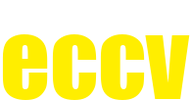

In [1]:
from trdg.generators import GeneratorFromStrings
generator = GeneratorFromStrings(
    strings=['eccv'],
    count=1,  # 五种字体
    fonts=['Impact.ttf'],  # default: []
    language='en',
    size=100,  # 32
    skewing_angle=0,
    random_skew=False,
    blur=0,
    random_blur=False,
    # gaussian noise (0), plain white (1), quasicrystal (2) or picture (3)
    background_type=1,
    distorsion_type=0,  # None(0), Sine wave(1),Cosine wave(2),Random(3)
    distorsion_orientation=0,
    is_handwritten=False,
    width=-1,
    alignment=1,
    text_color='#FFEE00',
    orientation=0,
    space_width=1.0,
    character_spacing=0,
    margins=(0, 0, 0, 0),
    fit=True,
)
img_list = [img for img, _ in generator]
wm_img = img_list[0]
wm_img

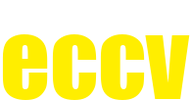

In [2]:
wm_img